# ATP Tennis Data - Raw History Data (5 Matches)



We will only add the following columns for each player:

* wins - matches won
* losses - matches lost
* games won
* sets won
* games lost
* sets lost

We will see if this data helps improve our models

### Results from Decision Tree Classifier with player diff + one hot encoded categorial features:

```
Model Score: 0.6906819716407833

ROC/AUC Score: 0.6906426130517523
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.69      7381
         Win       0.69      0.70      0.70      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810
```

# Summary of Results

There is a slight accuracy decrease when we only use raw history data for both players

```
Model Score: 0.6890614449696151

ROC/AUC Score: 0.6890347623400455
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.69      7381
         Win       0.69      0.70      0.69      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, RSTATE, N_JOBS, MAX_ITER, LABEL_COL

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "ohe-history_raw"

# sometimes I run these notebooks via command line. Environment variable is set so we know whether we are in DEBUG mode or not
# if you want to manually run this in DEBUG mode, change default value to True
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

if DEBUG:
    ModelWrapper.REPORT_FILE = '../reports/summary-test.csv'
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features_test-ohe-history5-matchup5-stats5.csv'
    DESCRIPTION = f"{DESCRIPTION}-test"
else:
    # update this
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-ohe-history5-matchup5-stats5.csv'


START_YEAR = 1998
END_YEAR = 2018




In [2]:
import re

def filter_features(data: pd.DataFrame):
    print(f'Before: data.shape {data.shape} data.shape {data.shape}')

    # drop all matchup columns
    matchup_columns = [col for col in data.columns if re.search('matchup', col)]
    data = data.drop(matchup_columns, axis=1)

    # drop all history columns that doesn't have percentage or diff
    history_columns = [col for col in data.columns if re.search('history.+(percentage|diff)', col)]
    data = data.drop(history_columns, axis=1)

    stats_columns = [col for col in data.columns if re.search("stats", col)]
    data = data.drop(stats_columns, axis=1)

    print(f'After: data.shape {data.shape} data.shape {data.shape}')    
    return data
     



In [3]:
X_train, X_test, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR, data_filter = filter_features)

Before: data.shape (59239, 5371) data.shape (59239, 5371)
After: data.shape (59239, 5271) data.shape (59239, 5271)


Our dataset actually has both historical data as well as matchup data. We will remove the matchup columns from the dataset

These are the history columns that we kept

In [4]:
[col for col in X_train.columns if re.search('history', col)]

['p1_history_games_lost',
 'p1_history_games_won',
 'p1_history_losses',
 'p1_history_sets_lost',
 'p1_history_sets_won',
 'p1_history_wins',
 'p2_history_games_lost',
 'p2_history_games_won',
 'p2_history_losses',
 'p2_history_sets_lost',
 'p2_history_sets_won',
 'p2_history_wins',
 'p1_history_matches',
 'p2_history_matches']

# Logistic Regression

In [5]:

# train our model

lr = ModelWrapper(LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_lr = lr.predict()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

Model Score: 0.6629304523970291

ROC/AUC Score: 0.6629299754607813
              precision    recall  f1-score   support

        Loss       0.66      0.66      0.66      7381
         Win       0.66      0.66      0.66      7429

    accuracy                           0.66     14810
   macro avg       0.66      0.66      0.66     14810
weighted avg       0.66      0.66      0.66     14810

      Loss   Win
Loss  4892  2489
Win   2503  4926


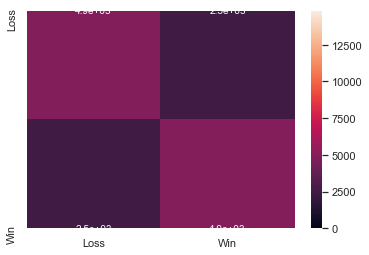

In [6]:
lr.analyze()

In [7]:
# ju.plot_2d(X_test, y_predict_lr)

In [8]:
lr.save()

Saving report: ../reports/summary.csv


# KNN

In [9]:

# train our model

knn = ModelWrapper(KNeighborsClassifier(n_jobs = N_JOBS),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_knn = knn.predict()

TypeError: fit() takes 3 positional arguments but 4 were given

In [10]:
knn.analyze()

NameError: name 'knn' is not defined

In [11]:
# ju.plot_2d(X_test, y_predict_knn)

In [12]:
knn.save()

NameError: name 'knn' is not defined

# Decision Tree

In [13]:

# train our model

dt = ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_dt = dt.predict()

Model Score: 0.6082376772451047

ROC/AUC Score: 0.6082112398218831
              precision    recall  f1-score   support

        Loss       0.61      0.60      0.60      7381
         Win       0.61      0.62      0.61      7429

    accuracy                           0.61     14810
   macro avg       0.61      0.61      0.61     14810
weighted avg       0.61      0.61      0.61     14810

      Loss   Win
Loss  4429  2952
Win   2850  4579


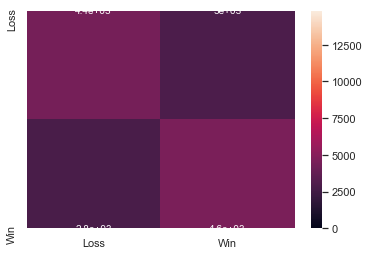

In [14]:
dt.analyze()

In [15]:
# ju.plot_2d(X_test, y_predict_dt)

In [16]:
dt.save()

Saving report: ../reports/summary.csv


# Random Forest Classifier

In [17]:

# train our model

rf = ModelWrapper(RandomForestClassifier(random_state=RSTATE, verbose=1),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_rf = rf.predict()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Model Score: 0.6334908845374747

ROC/AUC Score: 0.6337321403948164
              precision    recall  f1-score   support

        Loss       0.61      0.71      0.66      7381
         Win       0.66      0.56      0.60      7429

    accuracy                           0.63     14810
   macro avg       0.64      0.63      0.63     14810
weighted avg       0.64      0.63      0.63     14810

      Loss   Win
Loss  5227  2154
Win   3274  4155


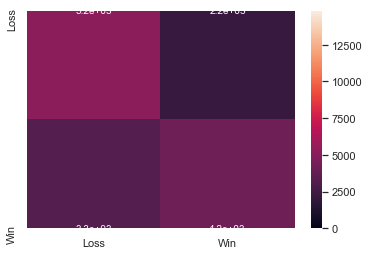

In [18]:
rf.analyze()

In [19]:
# ju.plot_2d(X_test, y_predict_rf)

In [20]:
rf.save()

Saving report: ../reports/summary.csv


# Gradient Boosting

In [21]:

# train our model

gb = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3670           12.41m
         2           1.3505           11.37m
         3           1.3357           11.64m
         4           1.3238           11.24m
         5           1.3131           10.86m
         6           1.3044           10.65m
         7           1.2958           10.41m
         8           1.2890           10.23m
         9           1.2825           10.06m
        10           1.2770            9.89m
        20           1.2402            8.61m
        30           1.2038            7.51m
        40           1.1872            6.62m
        50           1.1743            5.58m
        60           1.1676            4.50m
        70           1.1628            3.40m
        80           1.1571            2.27m
        90           1.1506            1.14m
       100           1.1480            0.00s


Model Score: 0.6890614449696151

ROC/AUC Score: 0.6890347623400455
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.69      7381
         Win       0.69      0.70      0.69      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810

      Loss   Win
Loss  5025  2356
Win   2249  5180


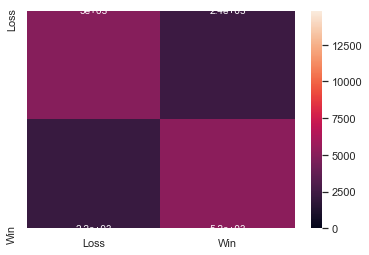

In [22]:
gb.analyze()

In [23]:
# ju.plot_2d(X_test, y_predict_gb)

In [24]:
gb.save()

Saving report: ../reports/summary.csv


# AdaBoost

In [25]:
ab = ModelWrapper(AdaBoostClassifier(random_state=RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_ab = ab.predict()

Model Score: 0.6682646860229574

ROC/AUC Score: 0.6682084597669572
              precision    recall  f1-score   support

        Loss       0.67      0.65      0.66      7381
         Win       0.66      0.69      0.67      7429

    accuracy                           0.67     14810
   macro avg       0.67      0.67      0.67     14810
weighted avg       0.67      0.67      0.67     14810

      Loss   Win
Loss  4804  2577
Win   2336  5093


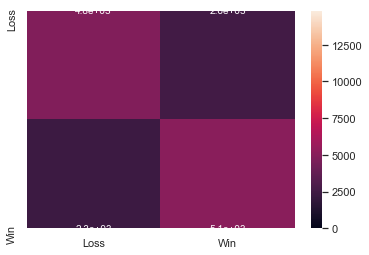

In [26]:
ab.analyze()

In [27]:
# ju.plot_2d(X_test, y_predict_ab)

In [28]:
ab.save()

Saving report: ../reports/summary.csv


# Results


In [29]:
report = pd.read_csv(ModelWrapper.REPORT_FILE)
report.tail(6)

,accuracy,classification_report,confusion_matrix,data_file,data_filter_file,description,end_year,fit_time_min,model_file,model_name,predict_time_min,roc_auc_score,start_year,total_time_min
184,0.672384,"{""Loss"": {""precision"": 0.6750657621486916, ""re...","{""0"": {""0"": 4876, ""1"": 2347}, ""1"": {""0"": 2505,...",../datasets/atp_matches_1985-2019_features-ohe...,../models/adaboostclassifier-1998-2018-ohe-his...,ohe-history_all,2018,1.0,../models/adaboostclassifier-1998-2018-ohe-his...,AdaBoostClassifier,0.0,0.672346,1998,1.0
185,0.662930,"{""Loss"": {""precision"": 0.661528059499662, ""rec...","{""0"": {""0"": 4892, ""1"": 2503}, ""1"": {""0"": 2489,...",../datasets/atp_matches_1985-2019_features-ohe...,../models/logisticregression-1998-2018-ohe-his...,ohe-history_raw,2018,0.0,../models/logisticregression-1998-2018-ohe-his...,LogisticRegression,0.0,0.662930,1998,0.0
186,0.608238,"{""Loss"": {""precision"": 0.6084627009204561, ""re...","{""0"": {""0"": 4429, ""1"": 2850}, ""1"": {""0"": 2952,...",../datasets/atp_matches_1985-2019_features-ohe...,../models/decisiontreeclassifier-1998-2018-ohe...,ohe-history_raw,2018,0.0,../models/decisiontreeclassifier-1998-2018-ohe...,DecisionTreeClassifier,0.0,0.608211,1998,0.0
187,0.633491,"{""Loss"": {""precision"": 0.6148688389601223, ""re...","{""0"": {""0"": 5227, ""1"": 3274}, ""1"": {""0"": 2154,...",../datasets/atp_matches_1985-2019_features-ohe...,../models/randomforestclassifier-1998-2018-ohe...,ohe-history_raw,2018,0.0,../models/randomforestclassifier-1998-2018-ohe...,RandomForestClassifier,0.0,0.633732,1998,0.0
188,0.689061,"{""Loss"": {""precision"": 0.6908166070937586, ""re...","{""0"": {""0"": 5025, ""1"": 2249}, ""1"": {""0"": 2356,...",../datasets/atp_matches_1985-2019_features-ohe...,../models/gradientboostingclassifier-1998-2018...,ohe-history_raw,2018,11.0,../models/gradientboostingclassifier-1998-2018...,GradientBoostingClassifier,0.0,0.689035,1998,11.0
189,0.668265,"{""Loss"": {""precision"": 0.6728291316526611, ""re...","{""0"": {""0"": 4804, ""1"": 2336}, ""1"": {""0"": 2577,...",../datasets/atp_matches_1985-2019_features-ohe...,../models/adaboostclassifier-1998-2018-ohe-his...,ohe-history_raw,2018,1.0,../models/adaboostclassifier-1998-2018-ohe-his...,AdaBoostClassifier,0.0,0.668208,1998,1.0


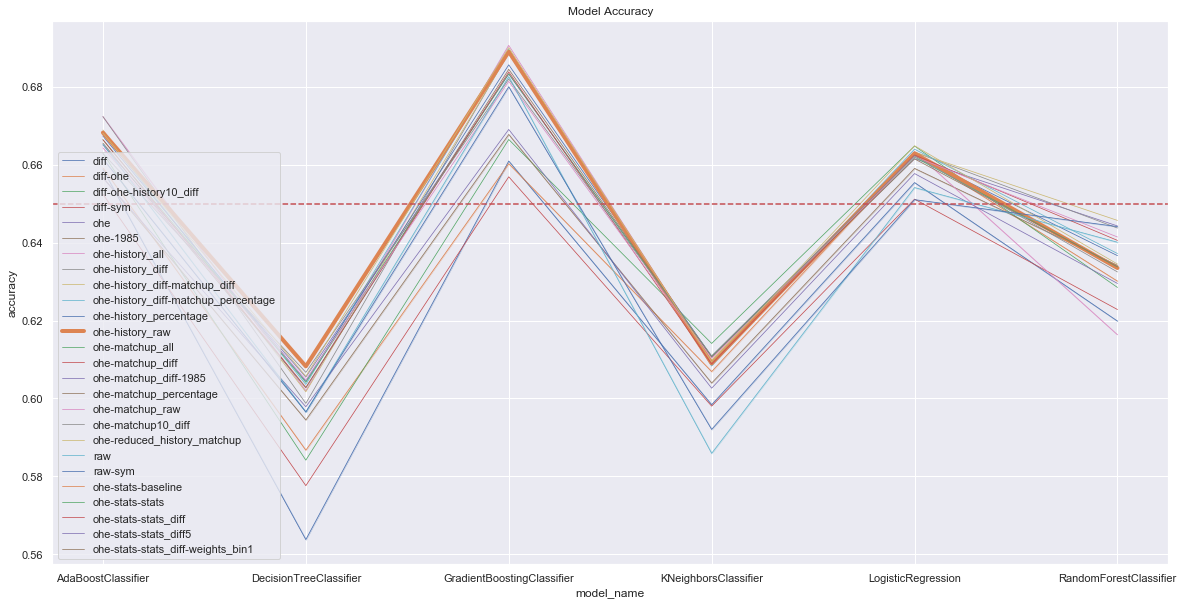

In [30]:
f, a = plt.subplots(1, 1, figsize=(20, 10))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    if desc == DESCRIPTION:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=4)
    else:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=0.75)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")
_ = a.legend(loc="lower left")

Best Model: GradientBoostingClassifier


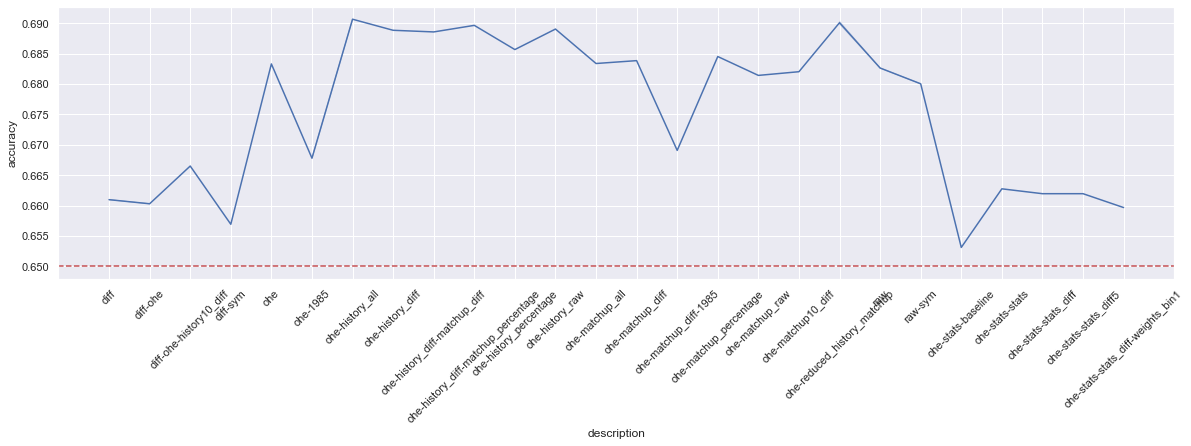

In [31]:
best_model = report.loc[report[report.description == DESCRIPTION].accuracy.idxmax()].model_name
print(f'Best Model: {best_model}')

dt_report = report[(report.model_name == best_model)]

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
_ = a.axhline(0.65, ls='--', color='r')
_ = a.set_label(f"{best_model} Accuracy")
_ = plt.xticks(rotation=45)


In [32]:
current_report = report[(report.model_name == 'GradientBoostingClassifier') &
                                  (report.description == DESCRIPTION)]
mw = ModelWrapper.get_model_wrapper_from_report(current_report)


AssertionError: data must of length 1 - got 2

In [33]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(mw.model, data=X_train.values)
shap_values = explainer.shap_values(X_test.values)

NameError: name 'mw' is not defined

In [34]:
shap.summary_plot(shap_values, X_test, max_display=30)

NameError: name 'shap_values' is not defined

In [35]:
shap.summary_plot(shap_values, feature_names=X_test.columns, title="Feature Importance")

NameError: name 'shap_values' is not defined

In [36]:
print(f'Last Finished: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

Last Finished: 2019-10-26 12:03
